In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras
import tensorflow_decision_forests as tfdf

import lbg_forecast.noise as noise
import lbg_forecast.colour_cuts as cuts

import optimise_stellar as stellar

from sklearn.model_selection import train_test_split


In [2]:
def build_redshift_distribution_samples_object(u_data, g_data, r_data):

    u_redshifts = cuts.get_zs(u_data)
    g_redshifts = cuts.get_zs(g_data)
    r_redshifts = cuts.get_zs(r_data)

    redshift_array = np.empty(3, object)
    redshift_array[:] = [u_redshifts, g_redshifts, r_redshifts]     

    return redshift_array

def generate_training_data_labels(redshifts, zmin, zmax):
    '''
    dropout between zmin=zmax -> label=1; else=0
    '''

    labels = np.zeros_like(redshifts)
    u_indexes = np.where((redshifts > zmin) & (redshifts < zmax) )[0]#& (data[:, 0] - data[:, 1] > 0.0))[0]
    labels[u_indexes] = 1

    return labels

def create_test_validation_data(data, labels, validation_split, batch_size):
    """turns output of prepare data into tensorflow dataset, given test/training
    split and batch size
    """
    dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    validation_split = validation_split
    train_size = int(validation_split * data.shape[0])
    test_size = data.shape[0] - train_size

    train_dataset = dataset.take(train_size)
    test_dataset = dataset.skip(train_size)

    train_dataset = train_dataset.batch(batch_size=batch_size)
    test_dataset = test_dataset.batch(batch_size=batch_size)

    return train_dataset, test_dataset, train_size, test_size

def make_prediction(model, dataset):
    """return predicted labels (between 0 and 1) for
    a given tensorflow dataset
    """
    labels = model.predict(dataset)
    return labels[:, 0]

def make_prediction_at_confidence(model, dataset, confidence_level):
    """return predicted labels (0 or 1) for
    a given tensorflow dataset, for given a confidence level
    """
    labels = make_prediction(model, dataset)
    predicted_labels_at_confidence = np.where(labels > confidence_level, 1.0, 0.0)
    return predicted_labels_at_confidence

def get_optimised_nz(model, dataset, redshifts, confidence_level):
    predicted_labels = make_prediction_at_confidence(model, dataset, confidence_level)
    selected = redshifts[np.where(predicted_labels == 1.0)[0]]
    return selected

def get_binned_nz(redshifts, zl, zh):
    binned = redshifts[np.where((redshifts > zl) & (redshifts < zh) )[0]]
    return binned

def get_interlopers(redshifts):
    interlopers = redshifts[np.where(redshifts < 1.5)[0]]
    return interlopers

def get_interloper_fraction(redshifts):
    n_interlopers = get_interlopers(redshifts).shape[0]
    return (n_interlopers/redshifts.shape[0])*100

def confusion_matrix(original_labels, predicted_labels):
    cmatrix = tf.math.confusion_matrix(original_labels, predicted_labels)
    print(cmatrix)
    # TN FP
    # FN TP
    return cmatrix

def evaluate_model_performance(model, dataset, redshifts, original_labels, confidence_level, zl, zh):

    cmatrix = confusion_matrix(original_labels, make_prediction_at_confidence(model, dataset, confidence_level))
    selected_objects = get_optimised_nz(model, dataset, redshifts, confidence_level)
    original_objects = get_binned_nz(redshifts, zl, zh)
    ninterlopers =  get_interlopers(selected_objects).shape[0]

    print("efficency(%): ", float(((cmatrix[1, 1])/original_objects.shape[0])*100))
    print("purity(%): ", float((cmatrix[1, 1]/(cmatrix[0,1]+cmatrix[1, 1]))*100)) #of all positives - which are truly lbgs?
    print("interloper fraction(%): ", (ninterlopers/selected_objects.shape[0])*100) 

(500000, 17) (500000, 5) (500000, 4) mean redshift: 2.781913945007484


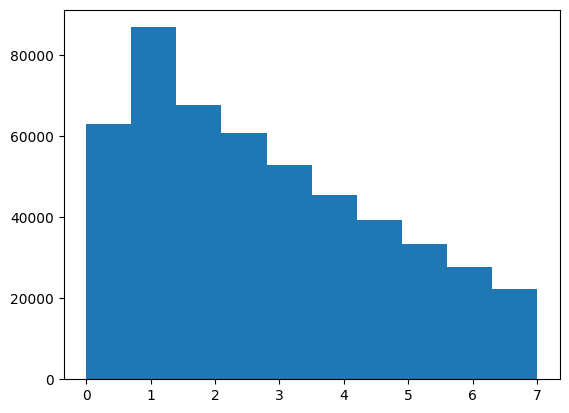

In [3]:
size=500000
train_sps = np.load('optimise_training_data/sps_hpc_pop_4m_mean_opt.npy')[0][:size, :]
train_phot = np.load('optimise_training_data/photo_hpc_pop_4m_mean_opt.npy')[0][:size, :] 

train_colours = cuts.calculate_colours(train_phot)
train_redshift = train_sps[:, 0]
print(train_sps.shape, train_phot.shape, train_colours.shape, 'mean redshift:' ,np.mean(train_redshift))
red_prior = plt.hist(train_redshift)

In [4]:
all_dropouts_mags = noise.get_noisy_magnitudes(train_sps, train_phot)
all_dropouts_colours = cuts.colours(all_dropouts_mags)

u_colours = all_dropouts_colours[0][1]
g_colours = all_dropouts_colours[1][1]
r_colours = all_dropouts_colours[2][1]

u_redshift = all_dropouts_colours[0][0][:, 0]
g_redshift = all_dropouts_colours[1][0][:, 0]
r_redshift = all_dropouts_colours[2][0][:, 0]

train_colours_noise = u_colours
train_redshift = u_redshift

print(train_colours_noise.shape)

u_labels = generate_training_data_labels(u_redshift, 2.5, 3.5)
g_labels = generate_training_data_labels(g_redshift, 3.5, 4.5)
r_labels = generate_training_data_labels(r_redshift, 4.5, 5.5)

(113027, 4)


In [5]:
def create_dataset(train_colours, labels, redshift):

    dataframe = pd.DataFrame({'umg':train_colours[:, 0],
             'gmr':train_colours[:, 1],
             'rmi':train_colours[:, 2],
             'imz':train_colours[:, 3],
             'labels':labels,
             'weights':np.ones_like(labels),
             'redshifts':redshift})

    dataframe['weights'] = dataframe['labels'].apply(lambda x: 1.0 if x == 1 else 1.0)
    train_df, test_df = train_test_split(dataframe, test_size=0.2, random_state=42)

    train_red = train_df['redshifts'].to_numpy()
    test_red = test_df['redshifts'].to_numpy()

    train_df = train_df.drop(columns=['redshifts'])
    test_df = test_df.drop(columns=['redshifts'])

    train_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label="labels", weight="weights")
    test_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label="labels", weight="weights")

    return train_dataset, test_dataset, train_red, test_red, test_df['labels'].to_numpy()

def train_model(train_colours, labels, redshift):

    train_dataset, test_dataset, train_red, test_red, test_labels = create_dataset(train_colours, labels, redshift)

    model = tfdf.keras.RandomForestModel(max_depth=256, verbose=2, task=tfdf.keras.Task.CLASSIFICATION, num_trees=5000)
    model.fit(train_dataset)

    model.compile(metrics=["accuracy"])
    evaluation = model.evaluate(test_dataset, return_dict=True)

    for name, value in evaluation.items():
        print(f"{name}: {value:.4f}")

    return model, train_dataset, test_dataset, train_red, test_red, test_labels
    

def test_model(model, test_dataset, test_red, test_labels, confidence, zl, zh):

    z_bins = np.linspace(0.0, 7.0, 50)
    original_objects = get_binned_nz(test_red, zl, zh)
    selected_objects = get_optimised_nz(model, test_dataset, test_red, confidence)
    #plt.hist(original_objects, density=True, label="True LBGs", bins=z_bins, alpha=0.5)
    #plt.hist(selected_objects, density=True, label="Selected LBGs", bins=z_bins, alpha=0.5)
    #plt.legend()
    #evaluate_model_performance(model, test_dataset, test_red, test_labels, confidence, zl, zh)

    return original_objects, selected_objects, z_bins


In [6]:
model_u, train_dataset_u, test_dataset_u, train_red_u, test_red_u, test_labels_u = train_model(u_colours, u_labels, u_redshift)
model_g, train_dataset_g, test_dataset_g, train_red_g, test_red_g, test_labels_g = train_model(g_colours, g_labels, g_redshift)
model_r, train_dataset_r, test_dataset_r, train_red_r, test_red_r, test_labels_r = train_model(r_colours, r_labels, r_redshift)

Use 10 thread(s) for training
Use /var/folders/s9/j1tshp4s5019kbkk8hz2q9840000gn/T/tmpoeqycsad as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'umg': <tf.Tensor 'data:0' shape=(None,) dtype=float64>, 'gmr': <tf.Tensor 'data_1:0' shape=(None,) dtype=float64>, 'rmi': <tf.Tensor 'data_2:0' shape=(None,) dtype=float64>, 'imz': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>}
Label: Tensor("data_4:0", shape=(None,), dtype=float64)
Weights: Tensor("data_5:0", shape=(None,), dtype=float64)
Normalized tensor features:
 {'umg': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast:0' shape=(None,) dtype=float32>), 'gmr': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_1:0' shape=(None,) dtype=float32>), 'rmi': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_2:0' shape=(None,) dtype=float32>), 'imz': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_3:0'

23/23 [==============================] - 13s 558ms/step - loss: 0.0000e+00 - accuracy: 0.9585
loss: 0.0000
accuracy: 0.9585
Use 10 thread(s) for training
Use /var/folders/s9/j1tshp4s5019kbkk8hz2q9840000gn/T/tmpry0xwkzb as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'umg': <tf.Tensor 'data:0' shape=(None,) dtype=float64>, 'gmr': <tf.Tensor 'data_1:0' shape=(None,) dtype=float64>, 'rmi': <tf.Tensor 'data_2:0' shape=(None,) dtype=float64>, 'imz': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>}
Label: Tensor("data_4:0", shape=(None,), dtype=float64)
Weights: Tensor("data_5:0", shape=(None,), dtype=float64)
Normalized tensor features:
 {'umg': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast:0' shape=(None,) dtype=float32>), 'gmr': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_1:0' shape=(None,) dtype=float32>), 'rmi': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'C

43/43 [==============================] - 40s 918ms/step - loss: 0.0000e+00 - accuracy: 0.9550
loss: 0.0000
accuracy: 0.9550
Use 10 thread(s) for training
Use /var/folders/s9/j1tshp4s5019kbkk8hz2q9840000gn/T/tmpxt1ejo8f as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'umg': <tf.Tensor 'data:0' shape=(None,) dtype=float64>, 'gmr': <tf.Tensor 'data_1:0' shape=(None,) dtype=float64>, 'rmi': <tf.Tensor 'data_2:0' shape=(None,) dtype=float64>, 'imz': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>}
Label: Tensor("data_4:0", shape=(None,), dtype=float64)
Weights: Tensor("data_5:0", shape=(None,), dtype=float64)
Normalized tensor features:
 {'umg': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast:0' shape=(None,) dtype=float32>), 'gmr': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_1:0' shape=(None,) dtype=float32>), 'rmi': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'C

37/37 [==============================] - 10s 260ms/step - loss: 0.0000e+00 - accuracy: 0.9839
loss: 0.0000
accuracy: 0.9839


In [7]:
#apply noise, the perform SNR, brightness and faintness cuts
all_dropouts_mags = noise.get_noisy_magnitudes(train_sps, train_phot)

#convert magnitudes to colours
all_dropouts_colours = cuts.colours(all_dropouts_mags)

#apply LBG colour cuts
u_data, g_data, r_data = cuts.apply_cuts_to_colours(all_dropouts_colours)

#get selected redshift samples and combine into object array
nzs = build_redshift_distribution_samples_object(u_data, g_data, r_data)

37/37 [==============================] - 9s 239ms/step


3.2907159716758456
4.172145845786013 8.29089316028695 3.305337306962883
4.925156929019797 5.6426332288401255 2.7139874739039667


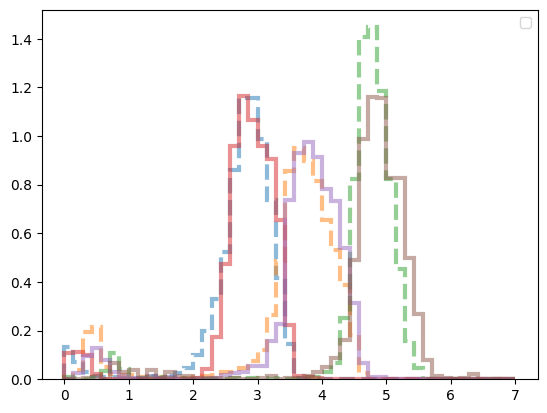

In [8]:
confidence=0.6 

original_objects_u, selected_objects_u, z_bins_u = test_model(model_u, test_dataset_u, test_red_u, test_labels_u, confidence=confidence, zl=2.5, zh=3.5)
original_objects_g, selected_objects_g, z_bins_g = test_model(model_g, test_dataset_g, test_red_g, test_labels_g, confidence=confidence, zl=3.5, zh=4.5)
original_objects_r, selected_objects_r, z_bins_r = test_model(model_r, test_dataset_r, test_red_r, test_labels_r, confidence=confidence, zl=4.5, zh=5.5)

bins = np.linspace(0, 7, 50)
alpha=0.5

u_nz = plt.hist(nzs[0], bins=bins, alpha=alpha, density=True, histtype='step', ls='--', lw=3)
g_nz = plt.hist(nzs[1], bins=bins, alpha=alpha, density=True, histtype='step', ls='--', lw=3)
r_nz = plt.hist(nzs[2], bins=bins, alpha=alpha, density=True, histtype='step', ls='--', lw=3)

u_nz = plt.hist(selected_objects_u, bins=bins, alpha=alpha, density=True, histtype='step', ls='-', lw=3)
g_nz = plt.hist(selected_objects_g, bins=bins, alpha=alpha, density=True, histtype='step', ls='-', lw=3)
r_nz = plt.hist(selected_objects_r, bins=bins, alpha=alpha, density=True, histtype='step', ls='-', lw=3)

plt.legend()

print(nzs[0].shape[0]/original_objects_u.shape[0])
print(get_interloper_fraction(nzs[0]), get_interloper_fraction(nzs[1]), get_interloper_fraction(nzs[2]))
print(get_interloper_fraction(selected_objects_u), get_interloper_fraction(selected_objects_g), get_interloper_fraction(selected_objects_r))

In [9]:
#xsl_colours = stellar.get_xsl_LSST_colours()
#xsl_labels = np.zeros(xsl_colours.shape[0])
#stellar.plot_xsl_colour_diagram()

In [10]:
#confidence = 0.7
#train_dataset, test_dataset, train_size, test_size = create_test_validation_data(xsl_colours, xsl_labels, 1.0, 1000)


#xsl_dataframe = pd.DataFrame({'umg':xsl_colours[:, 0],
#             'gmr':xsl_colours[:, 1],
#             'rmi':xsl_colours[:, 2],
#             'imz':xsl_colours[:, 3],
#             'labels':xsl_labels})

#xsl_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(xsl_dataframe, label="labels")


#classification = make_prediction_at_confidence(model, xsl_dataset, confidence)
#print("Stars Wrongly Classified as Galaxies(%): ", ((np.where(classification > 0.0)[0]).shape[0]/xsl_labels.shape[0])*100)